# Tutorial 2: Swendsen-Wang Algorithm

In [1]:
import numpy as np
from scipy import constants, sparse
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numba import jit

plt.style.use("dark_background")

In [81]:
@jit(nopython=True)
def index1D(L_y, x, y):
    return x * L_y + y

@jit(nopython=True)
def index2D(L_y, n):
    return n // L_y, n % L_y


In [82]:
# a)
@jit(nopython=True)
def get_bond_array(L_x, L_y):
    nodes = np.arange(L_x * L_y)
    bonds = np.zeros((len(nodes)*2, 2), dtype=np.int16)

    for i, n in enumerate(nodes):
        x,y = index2D(L_y, n)
        x_neighbour = (x+1) % L_x
        y_neighbour = (y+1) % L_y
        bonds[2*i] = np.array([n, index1D(L_y, x, y_neighbour)])
        bonds[2*i+1] = np.array([n, index1D(L_y, x_neighbour, y)])

    return bonds

print(get_bond_array(3,3))

[[0 1]
 [0 3]
 [1 2]
 [1 4]
 [2 0]
 [2 5]
 [3 4]
 [3 6]
 [4 5]
 [4 7]
 [5 3]
 [5 8]
 [6 7]
 [6 0]
 [7 8]
 [7 1]
 [8 6]
 [8 2]]


In [83]:
L_x = 5 #side length of lattice
L_y = 5

bonds = get_bond_array(L_x, L_y)

In [84]:
# b)

L_x = 5
L_y = 5
N = L_x*L_y
bonds = get_bond_array(L_x, L_y)
spins = np.random.randint(0, 2, size=N) * 2 - 1


In [85]:
# c)

@jit(nopython=True)
def assign_weights(bonds, spins, J=1, T=4.2):
    w_bs = []
    for b in bonds:
        s1 = spins[b[0]]
        s2 = spins[b[1]]

        w_b=1

        if s1*s2 == -1:
            w_b=0
        elif np.exp(-2.*J/T) > np.random.rand():
            w_b=0

        w_bs.append(w_b)
    return w_bs

In [92]:
# d)
L_x = 5
L_y = 5

spins = np.random.randint(0, 2, size=L_x * L_y) * 2 - 1
bonds = get_bond_array(L_x, L_y)


def flip_cluster(spins, bonds, L_x, L_y, T):
    N = L_x * L_y
    weights = assign_weights(bonds, spins, T)

    # scipy.sparse is not compatible with numba ... :(
    graph = sparse.csr_matrix((weights, (bonds[:,0], bonds[:,1])), shape=(N,N))
    graph_combined = graph+graph.T

    cluster_cnt, cluster_labels = sparse.csgraph.connected_components(graph_combined, directed=False)

   # flipping the actual clusters
    for cluster in range(1,cluster_cnt):
        if np.random.rand() > 0.5:
            spins[cluster_labels == cluster] *= 1

    # flipping the single member clusters
    for idx in range(len(spins)):
        if not cluster_labels[idx]:
            if np.random.rand() > 0.5:
                spins[idx] *= -1

    return spins

In [93]:
# e)
@jit(nopython=True)
def system_energy(spins, bonds, J=1):
    return J * np.sum(spins[bonds[:,0]]*spins[bonds[:,1]])


@jit(nopython=True)
def system_magnetization(spins):
    return np.sum(spins)

E = system_energy(spins, bonds)
M = system_magnetization(spins)


In [94]:
#f)


def run_mc(T, L_x=6, L_y=6):

    spins = np.random.randint(0, 2, size=L_x * L_y) * 2 - 1
    bonds = get_bond_array(L_x, L_y)

    N_eq = 500
    N_flips = 2000
    N_sweeps = 20

    Es = [] # energies
    Ms = [] # magnetizations
    Iterations = []

    for i in range(N_flips):
        flip_cluster(spins, bonds, L_x, L_y, T)

        if i < N_eq:
            continue

        if N_flips % N_sweeps == 0:
            Es.append(system_energy(spins, bonds))
            Ms.append(system_magnetization(spins))
            Iterations.append(i)



    return np.mean(Es), np.mean(Ms), np.std(Es), np.std(Ms), len(Es)


def run_temperatures(Ts):
    Es = []
    Ms = []
    dEs = []
    dMs = []

    for T in Ts:
        #print("Running temperature {}".format(T))
        E, M, dE, dM, cnt = run_mc(T)
        Es.append(E)
        Ms.append(M)
        dEs.append(dE)
        dMs.append(dM)


    return Es, Ms, dEs, dMs, cnt


def make_plots(Ts, Es, Ms, cnt):
    plt.plot(Ts, Es, "-o", label="Energy mean over {} measurements".format(cnt))
    plt.xlabel("Temperature")
    plt.ylabel("Energy")
    plt.title("Energy mean Values")
    plt.legend()

    plt.figure()
    plt.plot(Ts, Ms, "-o", label="Magnetization mean over {} measurements".format(cnt))

    plt.xlabel("Temperature")
    plt.ylabel("Magentization")
    plt.title("Magnetization mean Values")
    plt.legend()

    plt.show()


In [89]:
Ts = np.arange(0.5, 2.5, 0.2)
Es, Ms, dEs, dMs, cnt = run_temperatures(Ts)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
Unknown attribute 'csr_matrix' of type Module(<module 'scipy.sparse' from '/Users/konstantinneureither/OneDrive/DOKUMENTE/1_STUDIUM/02_MASTER/2021_SS/01_ComputationalManyBodyPhysics/tutorial/compMBP/venv/lib/python3.8/site-packages/scipy/sparse/__init__.py'>)

File "<ipython-input-86-a24a8627e929>", line 14:
def flip_cluster(spins, bonds, L_x, L_y, T):
    <source elided>

    graph = sparse.csr_matrix((weights, (bonds[:,0], bonds[:,1])), shape=(N,N))
    ^

During: typing of get attribute at <ipython-input-86-a24a8627e929> (14)

File "<ipython-input-86-a24a8627e929>", line 14:
def flip_cluster(spins, bonds, L_x, L_y, T):
    <source elided>

    graph = sparse.csr_matrix((weights, (bonds[:,0], bonds[:,1])), shape=(N,N))
    ^

During: resolving callee type: type(CPUDispatcher(<function flip_cluster at 0x13d391ca0>))
During: typing of call at <ipython-input-88-c872c62c1b22> (18)

During: resolving callee type: type(CPUDispatcher(<function flip_cluster at 0x13d391ca0>))
During: typing of call at <ipython-input-88-c872c62c1b22> (18)

During: resolving callee type: type(CPUDispatcher(<function flip_cluster at 0x13d391ca0>))
During: typing of call at <ipython-input-88-c872c62c1b22> (18)


File "<ipython-input-88-c872c62c1b22>", line 18:
def run_mc(T, L_x=6, L_y=6):
    <source elided>
    for i in range(N_flips):
        flip_cluster(spins, bonds, L_x, L_y, T)
        ^


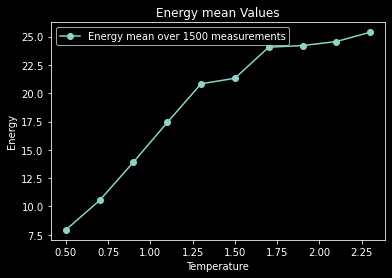

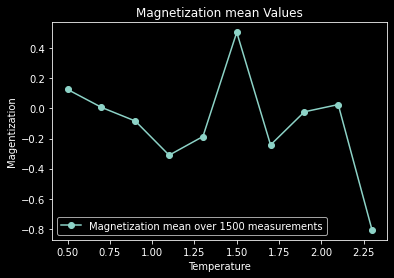

In [61]:
make_plots(Ts, Es, Ms, cnt)

In [96]:
Ts = np.arange(1.7, 2.7, .05)
Es, Ms, dEs, dMs, cnt = run_temperatures(Ts)

ValueError: x and y must have same first dimension, but have shapes (21,) and (10,)

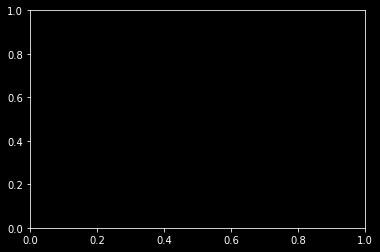

In [63]:
make_plots(Ts, Es, Ms, cnt)

In [73]:
def run_system_sizes():
    Ls = np.array([6,12,24])
    Ts = np.arange(1.7, 2.7, .05)

    Es = []
    Ms = []
    dEs = []
    dMs = []

    for L in tqdm(Ls):
        es = []
        ms = []
        des = []
        dms = []

        for T in tqdm(Ts):
            E, M, dE, dM, cnt = run_mc(T, L_x=L, L_y=L)

            es.append(E)
            ms.append(M)
            des.append(dE)
            dms.append(dM)

        Es.append(es)
        Ms.append(ms)
        dEs.append(des)
        dMs.append(dms)


    for i, L in enumerate(Ls):
        plt.errorbar(Ts, Es[i], yerr=dEs[i], label="L={}".format(L))

    plt.xlabel("Temperature")
    plt.ylabel("Energy / GeV")
    plt.title("Energy Mean Values (N={})".format(cnt))
    plt.legend()

    plt.figure()
    for i, L in enumerate(Ls):
        plt.errorbar(Ts, Ms[i], yerr=dMs[i], label="L={}".format(L))

    plt.xlabel("Temperature")
    plt.ylabel("Magnetization")
    plt.title("Magnetization Mean Values (N={})".format(cnt))
    plt.legend()

In [95]:
run_system_sizes()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

KeyboardInterrupt: 